# Sentimientos Cinematográficos: RNN vs LSTM

El análisis de sentimiento es una técnica clave en procesamiento de lenguaje natural (NLP) que clasifica opiniones expresadas en texto. En este proyecto, se comparan dos modelos de redes neuronales recurrentes (RNN) —una RNN simple y una LSTM— aplicados a reseñas de películas del dataset IMDB, compuesto por 50,000 reseñas etiquetadas como positivas o negativas.

Ambos modelos se entrenan utilizando tokenización y padding para convertir el texto en datos numéricos, y se optimizan mediante sintonización de hiperparámetros con Keras Tuner. El rendimiento de los modelos se evalúa con métricas como precisión, recall y AUC, complementadas con visualizaciones de curvas ROC y matrices de confusión.

Este proyecto no solo permite comparar el rendimiento de diferentes arquitecturas de RNN, sino que también demuestra el potencial del aprendizaje profundo en la clasificación automatizada de opiniones, con aplicaciones prácticas en áreas como comercio electrónico y redes sociales.

## Importar librerías necesarias

In [ ]:
# !pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

import warnings
warnings.filterwarnings("ignore")

## Cargar el dataset IMDb


In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 10000)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


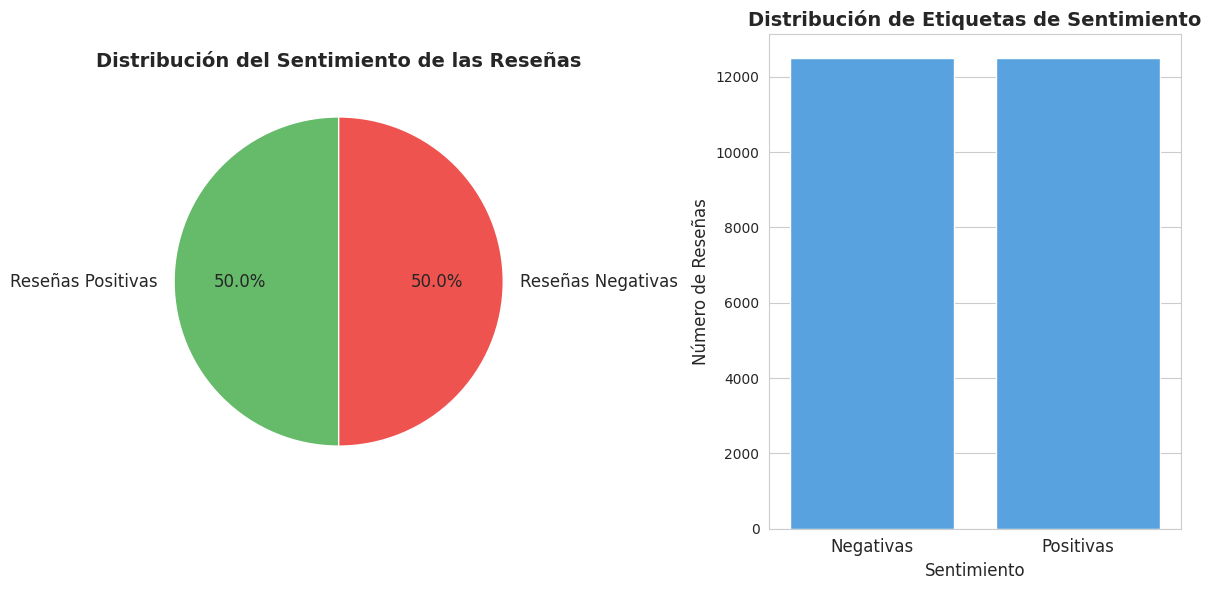

In [ ]:
# Visualización de la distribución de etiquetas del conjunto de entrenamiento
plt.figure(figsize=(12, 6))

# Gráfico de pastel
plt.subplot(1, 2, 1)
positivo = np.sum(y_train == 1)
negativo = np.sum(y_train == 0)
plt.pie([positivo, negativo],
        labels=['Reseñas Positivas', 'Reseñas Negativas'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#66BB6A', '#EF5350'],
        textprops={'fontsize': 12})
plt.title('Distribución del Sentimiento de las Reseñas', fontsize=14, weight='bold')

# Gráfico de barras
plt.subplot(1, 2, 2)
sns.set_style('whitegrid')
sns.set_palette(['#42A5F5', '#1E88E5'])
sns.countplot(x=y_train)
plt.xticks([0, 1], ['Negativas', 'Positivas'], fontsize=12)
plt.title('Distribución de Etiquetas de Sentimiento', fontsize=14, weight='bold')
plt.xlabel('Sentimiento', fontsize=12)
plt.ylabel('Número de Reseñas', fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# Preprocesamiento: relleno de secuencias para que todas tengan el mismo largo
max_len=100
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

## Función para construir el modelo RNN con hiperparámetros ajustables

In [ ]:
def build_model(hyperparam):
    # Inicialización del modelo secuencial
    model = Sequential()

    # Capa de Embedding: convierte los índices de palabras en vectores de características
    # El tamaño de la salida se ajusta dinámicamente con la búsqueda de hiperparámetros
    model.add(Embedding(input_dim=10000,  # El tamaño del vocabulario (10,000 palabras)
                        output_dim=hyperparam.Int("embedding_output", min_value=64, max_value=300, step=32),  # Dimensión de los vectores de embedding
                        input_length=max_len,  # Longitud máxima de las secuencias de entrada
                        embeddings_regularizer=l2(1e-4)))  # Regularización L2 para evitar sobreajuste en las embeddings

    # Primera capa RNN: red neuronal recurrente con unidades ajustables
    model.add(SimpleRNN(units=hyperparam.Int("rnn_units_1", min_value=64, max_value=256, step=32),  # Número de unidades RNN
                        return_sequences=True))  # Devuelve las secuencias completas (para pasar a la siguiente capa RNN)

    # Segunda capa RNN: otra capa recurrente que reduce la dimensionalidad
    model.add(SimpleRNN(units=hyperparam.Int("rnn_units_2", min_value=32, max_value=128, step=32)))  # Número de unidades ajustables

    # Normalización por lotes: mejora la convergencia y reduce el sobreajuste
    model.add(BatchNormalization())

    # Capa de Dropout: evita el sobreajuste desactivando un porcentaje aleatorio de las unidades durante el entrenamiento
    model.add(Dropout(rate=hyperparam.Float("dropout_rate", min_value=0.2, max_value=0.5, step=0.1)))  # Tasa de dropout ajustable

    # Capa densa intermedia: red totalmente conectada con 64 unidades y activación ReLU
    model.add(Dense(64, activation="relu",  # Activación ReLU para introducir no linealidad
                    kernel_regularizer=l2(hyperparam.Float("l2_reg", min_value=1e-4, max_value=1e-2, step=1e-4))))  # Regularización L2 para evitar sobreajuste

    # Capa de salida: salida binaria con activación sigmoidea para clasificación positiva o negativa
    model.add(Dense(1, activation="sigmoid"))

    # Compilación del modelo: especificación del optimizador, función de pérdida y métricas
    model.compile(optimizer=hyperparam.Choice("optimizer", ["adam", "rmsprop"]),  # Elección entre Adam y RMSprop
                  loss="binary_crossentropy",  # Pérdida binaria para clasificación binaria
                  metrics=["accuracy", "AUC", keras.metrics.Precision(), keras.metrics.Recall()])  # Métricas de precisión, recall y AUC

    return model

In [ ]:
# Ajuste de hiperparámetros (Random Search)
tuner = RandomSearch(build_model, objective= "val_accuracy", max_trials=5, executions_per_trial=2,
                    directory="rnn_tuner_directory", project_name="imdb_rnn")

Reloading Tuner from rnn_tuner_directory/imdb_rnn/tuner0.json


In [ ]:
# Callbacks para entrenamiento
early_stopping = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

In [ ]:
# Buscar los mejores hiperparámetros
tuner.search(x_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping, reduce_lr])

Trial 5 Complete [00h 07m 37s]
val_accuracy: 0.8018999993801117

Best val_accuracy So Far: 0.8140000104904175
Total elapsed time: 00h 29m 44s


## Obtener el mejor modelo encontrado


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (32, 100, 192)         │     1,920,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (32, 100, 64)          │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (32, 128)              │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 128)              │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,969,985 (7.51 MB)

 Trainable params: 1,969,729 (7.51 MB)

 Non-trainable params: 256 (1.00 KB)

## Evaluar el modelo en datos de prueba

In [ ]:
results = best_model.evaluate(x_test, y_test)
print("Métricas de evaluación (RNN):")
for metric_name, value in zip(best_model.metrics_names, results):
    print(f"{metric_name}: {value:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - AUC: 0.8979 - accuracy: 0.8209 - loss: 0.5214 - precision: 0.8214 - recall: 0.8136
Métricas de evaluación (RNN):
loss: 0.5205
compile_metrics: 0.8209


In [ ]:
# Predicciones y reporte de clasificación
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.82     12500
           1       0.83      0.81      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



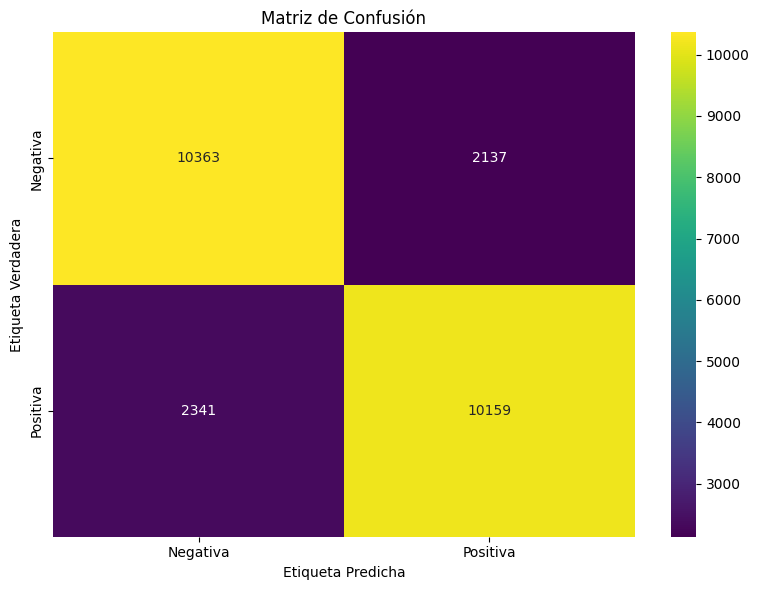

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='viridis',
            xticklabels=['Negativa', 'Positiva'],
            yticklabels=['Negativa', 'Positiva'])
plt.title('Matriz de Confusión')
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.tight_layout()
plt.show()

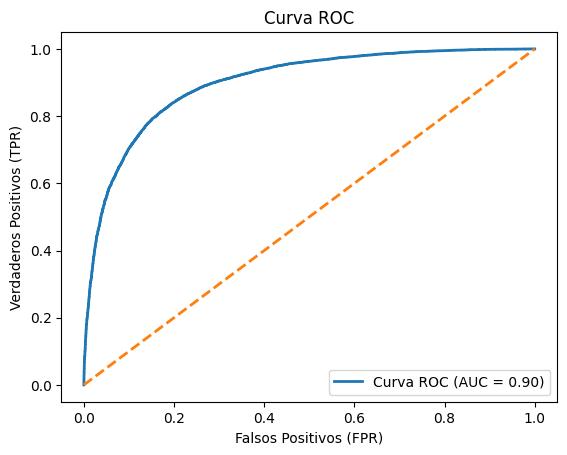

In [ ]:
# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label="Curva ROC (AUC = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
plt.xlabel("Falsos Positivos (FPR)")
plt.ylabel("Verdaderos Positivos (TPR)")
plt.title("Curva ROC")
plt.legend()
plt.show()

El modelo RNN alcanzó una precisión del 82% y un AUC de 0.90, demostrando una gran capacidad para clasificar correctamente reseñas como positivas o negativas. Las métricas de precisión y recall son equilibradas, lo que indica que el modelo no tiene sesgo hacia ninguna clase. La curva ROC refuerza estos resultados, mostrando un rendimiento destacado. Este modelo es efectivo para el análisis de sentimientos en reseñas y tiene un gran potencial en aplicaciones como redes sociales y atención al cliente.